In [15]:
import numpy as np

import tensorflow as tf

from keras.models import Model
from keras.layers import Dense, Input, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image

from keras_efficientnets import EfficientNetB0

from PIL import Image
import os

from keras.callbacks import EarlyStopping

from keras.callbacks import LearningRateScheduler
import keras.backend as K

from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

In [3]:
'''
Manual preprocessing for image datasets
'''

image_folder = r"../img"
images = []
labels = []
i = 0

for folder_imgName in os.listdir(image_folder):

    for files_name in os.listdir(image_folder + '/' + folder_imgName):

        if files_name.endswith(".png"):
            folder_path = image_folder + '/' + folder_imgName

            # img loading
            img = Image.open(os.path.join(folder_path, files_name))
            lbl = folder_imgName

            # preprocessing image
            img = img.resize((224, 224))  # resizingf for model
            img = np.array(img) / 255.0  # Normalisation (between 0 & 1)


            images.append(img)
            labels.append(lbl)

            if i == 0:
                img_test= img
                i==1


# preprocessing labels & convert to numpy array
labelB = LabelBinarizer()
train_labels = labelB.fit_transform(labels)

# image list to numpy array
train_images = np.array(images)

In [4]:
'''
Manual preprocessing for image datasets
'''

image_folder = r"../img_val"
images = []
labels = []
i = 0

for folder_imgName in os.listdir(image_folder):

    for files_name in os.listdir(image_folder + '/' + folder_imgName):

        if files_name.endswith(".png"):
            folder_path = image_folder + '/' + folder_imgName

            # img loading
            img = Image.open(os.path.join(folder_path, files_name))
            lbl = folder_imgName

            # preprocessing image
            img = img.resize((224, 224))  # resizingf for model
            img = np.array(img) / 255.0  # Normalisation (between 0 & 1)


            images.append(img)
            labels.append(lbl)

            if i == 0:
                imgs_test= img
                i==1


# preprocessing labels & convert to numpy array
labelB = LabelBinarizer()
val_labels = labelB.fit_transform(labels)

# image list to numpy array
val_images = np.array(images)

In [5]:
# définition des paramètres personalisés

# personal layers for VGG16 models
n_classes = 7
n_layers = 7
n_neurons_BeforeLast = 128
f_activation = 'relu'
f_activation_lastLayer = 'softmax'

# personal parameters for compilation
optimizer = 'Adagrad'
loss = 'categorical_crossentropy'

# personnal parameters for training (fitness)
epochs = 100
batch_size = 32

#numéro de l'essai
num_essai = '0_efficientNet'

file_name = (str(num_essai) + '_' + str(n_classes) + '_' + str(n_layers) +
'_' + str(n_neurons_BeforeLast) + '_' + str(f_activation) +
'_' + str(f_activation_lastLayer) + '_' + str(optimizer) +
'_' + str(loss) + '_' + str(epochs) + '_' + str(batch_size) )

In [6]:
# Model EfficientNetB0 loading without fully connected layers

input_shape = (224, 224, 3)  # Spécifiez la taille de l'entrée
input_tensor = Input(shape=input_shape)
base_model = EfficientNetB0(input_tensor=input_tensor, include_top=False, weights='imagenet')#, classes=1000)

In [7]:
# Freeze convolution layers to avoid training
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Add personnal layers for training
x = base_model.output

x = GlobalAveragePooling2D()(x)

for i in range(n_layers):
    x = Dense(n_neurons_BeforeLast * (n_classes-i), activation=f_activation)(x) #personal layer


predictions = Dense(n_classes, activation=f_activation_lastLayer)(x)  

In [9]:
# generate model VGG16 with personal fully connected layers
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [11]:
# def scheduler(epoch, lr):
#     if epoch < 12:
#         return lr
#     else:
#         return lr * K.exp(-0.1)

# lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [13]:
# Model training
model.fit(train_images, train_labels, epochs= epochs, batch_size= batch_size, validation_data=(val_images, val_labels), callbacks=[early_stopping])#, lr_scheduler

Epoch 1/100
175/175 [==============================] - 14s 57ms/step - loss: 1.8897 - accuracy: 0.3202 - val_loss: 1.8116 - val_accuracy: 0.4616
Epoch 2/100
175/175 [==============================] - 9s 51ms/step - loss: 1.6498 - accuracy: 0.5013 - val_loss: 1.4453 - val_accuracy: 0.5920
Epoch 3/100
175/175 [==============================] - 9s 51ms/step - loss: 1.2221 - accuracy: 0.6520 - val_loss: 1.0339 - val_accuracy: 0.6938
Epoch 4/100
175/175 [==============================] - 9s 51ms/step - loss: 0.8944 - accuracy: 0.7311 - val_loss: 0.7809 - val_accuracy: 0.7518
Epoch 5/100
175/175 [==============================] - 9s 51ms/step - loss: 0.7018 - accuracy: 0.7730 - val_loss: 0.6231 - val_accuracy: 0.8062
Epoch 6/100
175/175 [==============================] - 9s 51ms/step - loss: 0.5863 - accuracy: 0.8079 - val_loss: 0.5225 - val_accuracy: 0.8348
Epoch 7/100
175/175 [==============================] - 9s 51ms/step - loss: 0.5109 - accuracy: 0.8288 - val_loss: 0.4579 - val_accuracy

1/1 [==============================] - 1s 1s/step
[[1.8680792e-09 2.3271893e-07 2.8329364e-03 9.9586511e-01 5.1750500e-05
  1.2459417e-03 4.0573727e-06]]


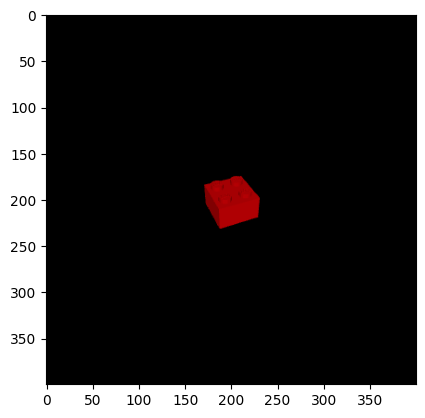

In [16]:
# Charger l'image à prédire
img_path = r"C:\Users\dimle\OneDrive\Bureau\10_ProtoJam\app_legoSort\img_test\3003\ImageToStl.com_3003 brick 2x2.png"
img = Image.open(img_path)
plt.imshow(img)

img = img.resize((224, 224))
# Prétraiter l'image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:,:,:3], axis=0)
img_array /= 255.0  # Normaliser les valeurs des pixels

# Faire une prédiction
predictions = model.predict(img_array)

# Afficher les prédictions
print(predictions)

In [17]:
id_max = np.argmax(predictions)
print(f'class la plus probable : {id_max} pour {predictions[0][id_max]:.2f} de probabilité')

class la plus probable : 3 pour 1.00 de probabilité


In [18]:
model.save(f"../model_saved/{num_essai}_model.h5py")

INFO:tensorflow:Assets written to: ../model_saved/0_efficientNet_model.h5py\assets


INFO:tensorflow:Assets written to: ../model_saved/0_efficientNet_model.h5py\assets
c:\Users\dimle\Documents\lego_classification\.conda\lib\site-packages\keras\engine\functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\dimle\Documents\lego_classification\.conda\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
